## Data analysis on ***"Big-Five Factor Markers"*** 
### 1.Load the processed dataset

In [0]:
file_location = "/FileStore/tables/data_processed.csv"

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv(file_location, header = True)
df.printSchema()

root
-- EXT1: string (nullable = true)
-- EXT2: string (nullable = true)
-- EXT3: string (nullable = true)
-- EXT4: string (nullable = true)
-- EXT5: string (nullable = true)
-- EXT6: string (nullable = true)
-- EXT7: string (nullable = true)
-- EXT8: string (nullable = true)
-- EXT9: string (nullable = true)
-- EXT10: string (nullable = true)
-- EST1: string (nullable = true)
-- EST2: string (nullable = true)
-- EST3: string (nullable = true)
-- EST4: string (nullable = true)
-- EST5: string (nullable = true)
-- EST6: string (nullable = true)
-- EST7: string (nullable = true)
-- EST8: string (nullable = true)
-- EST9: string (nullable = true)
-- EST10: string (nullable = true)
-- AGR1: string (nullable = true)
-- AGR2: string (nullable = true)
-- AGR3: string (nullable = true)
-- AGR4: string (nullable = true)
-- AGR5: string (nullable = true)
-- AGR6: string (nullable = true)
-- AGR7: string (nullable = true)
-- AGR8: string (nullable = true)
-- AGR9: string (nullable = true)
-- AGR10: string (nullable = true)
-- CSN1: string (nullable = true)
-- CSN2: string (nullable = true)
-- CSN3: string (nullable = true)
-- CSN4: string (nullable = true)
-- CSN5: string (nullable = true)
-- CSN6: string (nullable = true)
-- CSN7: string (nullable = true)
-- CSN8: string (nullable = true)
-- CSN9: string (nullable = true)
-- CSN10: string (nullable = true)
-- OPN1: string (nullable = true)
-- OPN2: string (nullable = true)
-- OPN3: string (nullable = true)
-- OPN4: string (nullable = true)
-- OPN5: string (nullable = true)
-- OPN6: string (nullable = true)
-- OPN7: string (nullable = true)
-- OPN8: string (nullable = true)
-- OPN9: string (nullable = true)
-- OPN10: string (nullable = true)
-- country: string (nullable = true)

In [0]:
print((df.count(), len(df.columns)))

(1012050, 51)

### 2.Processing data

In [0]:
from pyspark.sql.types import *

In [0]:
features = ["EXT1", "EXT2" ,"EXT3" ,"EXT4" ,"EXT5" ,"EXT6" ,"EXT7" ,"EXT8" ,"EXT9" ,"EXT10",
            "EST1" ,"EST2" ,"EST3" ,"EST4" ,"EST5" ,"EST6" ,"EST7" ,"EST8" ,"EST9" ,"EST10",
            "AGR1" ,"AGR2" ,"AGR3" ,"AGR4" ,"AGR5" ,"AGR6" ,"AGR7" ,"AGR8" ,"AGR9" ,"AGR10",
            "CSN1" ,"CSN2" ,"CSN3" ,"CSN4" ,"CSN5" ,"CSN6" ,"CSN7" ,"CSN8" ,"CSN9" ,"CSN10",
            "OPN1" ,"OPN2" ,"OPN3" ,"OPN4" ,"OPN5" ,"OPN6" ,"OPN7" ,"OPN8" ,"OPN9" ,"OPN10"
           ]


for each_feature in df.columns:
    if each_feature in features:
            df = df.withColumn(each_feature, df[each_feature].cast(FloatType()))

### 3.Exploring the data

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df[features].columns, outputCol=vector_col)
df_vector = assembler.transform(df[features]).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

Out[7]:

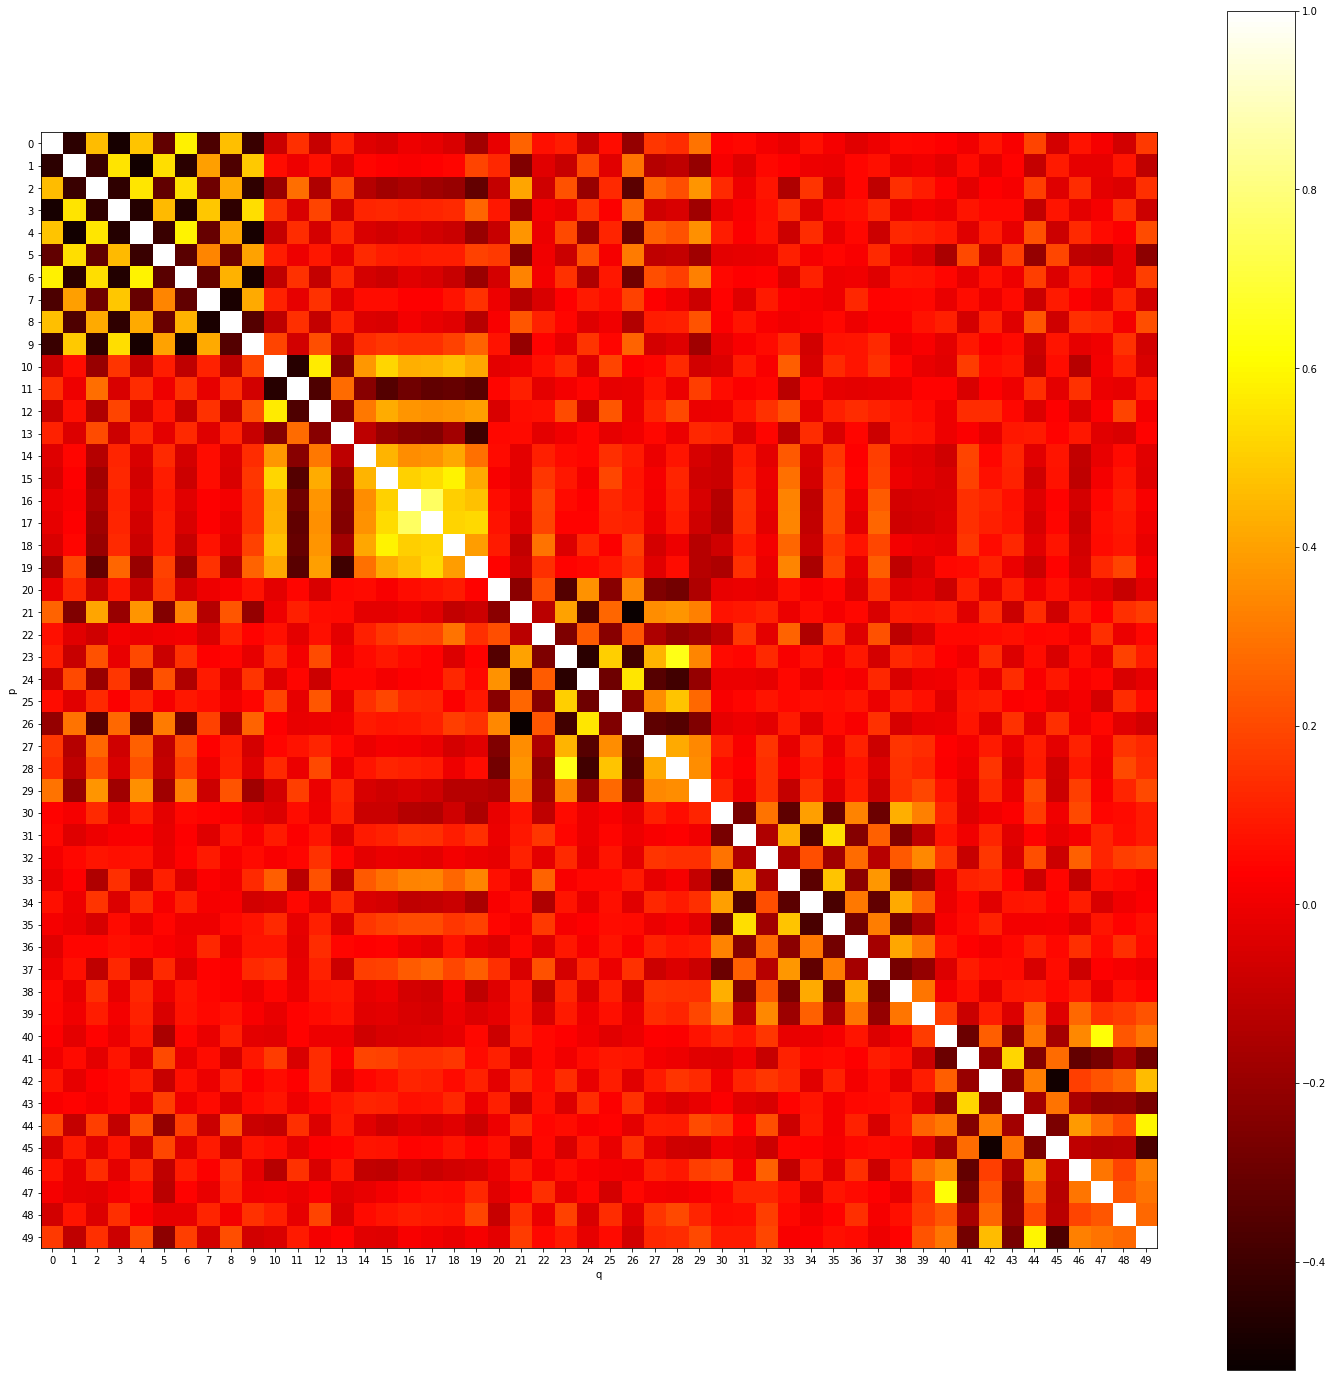

Text(0, 0.5, 'p')

In [0]:
from matplotlib import pyplot as plt
# import matplotlib as plt
import pandas as pd
import numpy as np
matrix =  matrix.collect()
a = matrix[0][0].toArray()
plt.figure(figsize=(25, 25))
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(50), labels=range(50))
plt.xlabel("q")
plt.yticks(ticks=range(50), labels=range(50))
plt.ylabel("p")

### 4.Preparing LabeledPoint for mllib

In [0]:
categorical_feats = ['country']
from pyspark.ml.feature import StringIndexer

td = df
for feat in categorical_feats:
    stringIndexer = StringIndexer(inputCol=feat, outputCol=feat+"_indexed")
    model = stringIndexer.fit(df)
    df = model.transform(df)

In [0]:
features = ["EXT1", "EXT2" ,"EXT3" ,"EXT4" ,"EXT5" ,"EXT6" ,"EXT7" ,"EXT8" ,"EXT9" ,"EXT10",
            "EST1" ,"EST2" ,"EST3" ,"EST4" ,"EST5" ,"EST6" ,"EST7" ,"EST8" ,"EST9" ,"EST10",
            "AGR1" ,"AGR2" ,"AGR3" ,"AGR4" ,"AGR5" ,"AGR6" ,"AGR7" ,"AGR8" ,"AGR9" ,"AGR10",
            "CSN1" ,"CSN2" ,"CSN3" ,"CSN4" ,"CSN5" ,"CSN6" ,"CSN7" ,"CSN8" ,"CSN9" ,"CSN10",
            "OPN1" ,"OPN2" ,"OPN3" ,"OPN4" ,"OPN5" ,"OPN6" ,"OPN7" ,"OPN8" ,"OPN9" ,"OPN10", "country_indexed"
           ]

In [0]:
new_df = df.select(features)

In [0]:
from pyspark.mllib.regression import LabeledPoint
no_0_df = new_df.rdd.filter(lambda row: row[0] > 0) # Make sure all labels are in 1 to 5
labelpointRDD_no_0 = no_0_df.map(lambda row:LabeledPoint(row[0], row[1:])) # convert the data into format of LabelPoint
labelpointRDD_no_0 = labelpointRDD_no_0.map(lambda x: LabeledPoint(x.label-1, x.features)) # convert label from 1-5 to 0-4
train_no_0, test_no_0 = labelpointRDD_no_0.randomSplit([0.8, 0.2]) # Split training and test sets

### 5.Multiclass logistic regression

In [0]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
model = LogisticRegressionWithLBFGS.train(train_no_0, numClasses=5)

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = test_no_0.map(lambda lp: (float(model.predict(lp.features)), lp.label))
metrics = MulticlassMetrics(predictionAndLabels)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print("Accuracy = %s" % metrics.accuracy)

Summary Stats
Precision = 0.3739029800366477
Recall = 0.09736068908364932
F1 Score = 0.15449292687786412
Accuracy = 0.46834784933724827

### 6.Random Forest

In [0]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

model = RandomForest.trainClassifier(train_no_0, numClasses=5, categoricalFeaturesInfo={},
                                     numTrees=5, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)

In [0]:
predictions = model.predict(test_no_0.map(lambda x: x.features))
labelsAndPredictions = test_no_0.map(lambda lp: lp.label).zip(predictions)
acc = labelsAndPredictions.filter(lambda x: x[0] == x[1]).count() / float(test_no_0.count())
print("Model accuracy: %.3f%%" % (acc * 100))

Model accuracy: 45.257%